 We will build a pokemon image classifier (pokedex) from scratch.

 You can build the image dataset using [this tool with bing image search api](https://github.com/Akshay090/bingoset). Then add it to a git repo and we will download it here as given below.

# Download Dataset

In [0]:
! git clone https://github.com/Akshay090/pokemon-image-dataset


# Initial Setings and Imports

Every notebook starts with the following three lines; They are called magic commands [read more about them here](https://ipython.readthedocs.io/en/stable/interactive/magics.html)

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline    

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

we set the batch size, Batch size means how many images to load into the main memory of your system for one training cycle. 

Maximum batch_size is limited by the memory that your system has -- main memory in case of CPU and GPU memory if you are using the GPU

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

Setting up the dataset path

In [0]:
from pathlib import Path
dataset_path = Path.cwd() / 'pokemon-image-dataset'
dataset_path

PosixPath('/data/home/akshay090/Learning-Space/pokemon-image-dataset')

In [0]:
for currentFile in dataset_path.iterdir():
    print(currentFile)

/data/home/akshay090/Learning-Space/pokemon-image-dataset/bulbasaur
/data/home/akshay090/Learning-Space/pokemon-image-dataset/pikachu
/data/home/akshay090/Learning-Space/pokemon-image-dataset/charmander
/data/home/akshay090/Learning-Space/pokemon-image-dataset/models
/data/home/akshay090/Learning-Space/pokemon-image-dataset/squirtle
/data/home/akshay090/Learning-Space/pokemon-image-dataset/.git


In [0]:
classes = ['pikachu','charmander','squirtle','bulbasaur']

np.random.seed(42) makes the random numbers predictable, the same set of numbers will appear every time

ImageDataBunch.from_folder is going to return a DataBunch object. In fastai, everything you model with is going to be a DataBunch object. Basically DataBunch object contains 2 or 3 datasets - it contains your training data, validation data, and optionally test data.

This might seem weird because images have size. This is a shortcoming of current deep learning technology which is that a GPU has to apply the exact same instruction to a whole bunch of things at the same time in order to be fast. If the images are different shapes and sizes, you can't do that. So we actually have to make all of the images the same shape and size. 

And thats what the function get_transforms() and normalize do.



In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path=dataset_path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
data.classes

['bulbasaur', 'charmander', 'pikachu', 'squirtle']

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['bulbasaur', 'charmander', 'pikachu', 'squirtle'], 4, 484, 121)

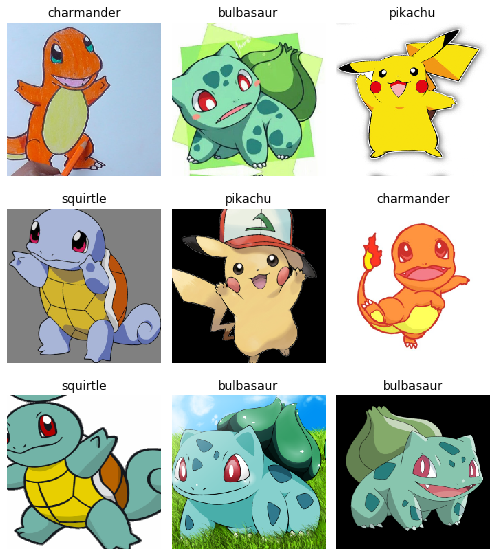

In [0]:
data.show_batch(rows=3, figsize=(7,8))

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry.

 For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 4 outputs).

We will train for 4 epochs (4 cycles through all our data).

 cnn_learner is used  to easily get a model suitable for transfer learning. Transfer learning is a technique where you use a model trained on a very large dataset (usually [ImageNet](http://image-net.org/) in computer vision) and then adapt it to your own dataset.

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.475397,0.173675,0.057851,00:11
1,0.746698,0.003842,0.000000,00:10
2,0.476820,0.003652,0.000000,00:10
3,0.340317,0.005128,0.000000,00:11


In [0]:
learn.save('stage-1')

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


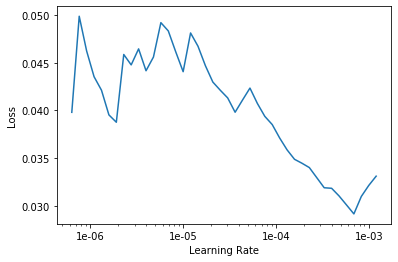

In [0]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.019142,0.114508,0.033058,00:20
1,0.015908,0.073927,0.016529,00:20


That's a pretty accurate model!

In [0]:
learn.save('stage-2')

## Interpretation

In [0]:
learn.load('stage-2');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

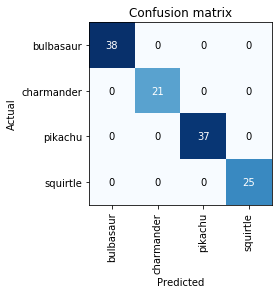

In [0]:
interp.plot_confusion_matrix()

In [0]:
interp.most_confused(min_val=1)

[]

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

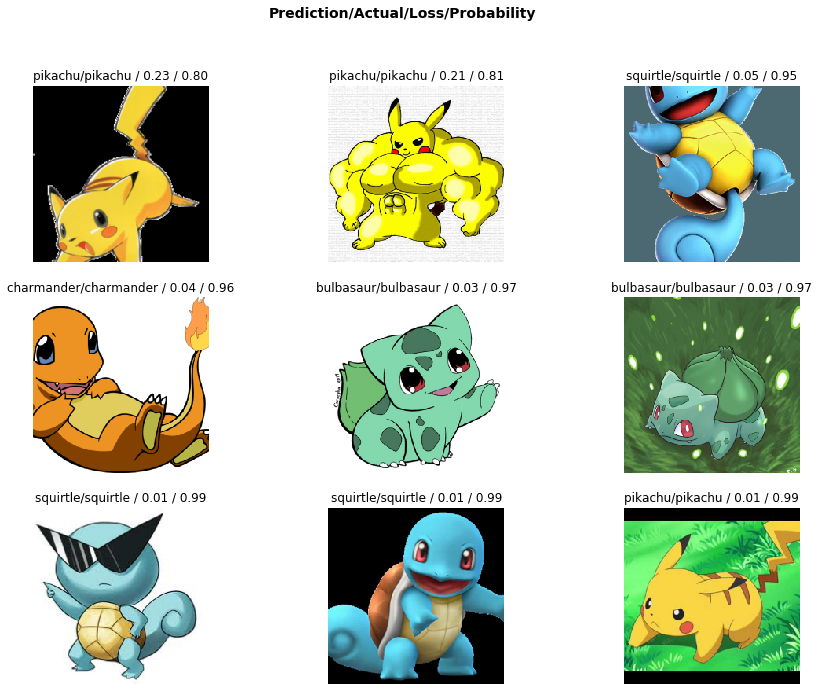

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

## Exporting model and testing it

In [0]:
output_folder = os.path.join(os.getcwd(), 'outputs')
model_name = 'poke_predictor_resnet34'  # Name we will give our model both locally and on Azure
pickled_model_name = f'{model_name}.pkl'
os.makedirs(output_folder, exist_ok=True)

learn.export(os.path.join(output_folder, pickled_model_name))

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

In [0]:
defaults.device = torch.device('cpu')

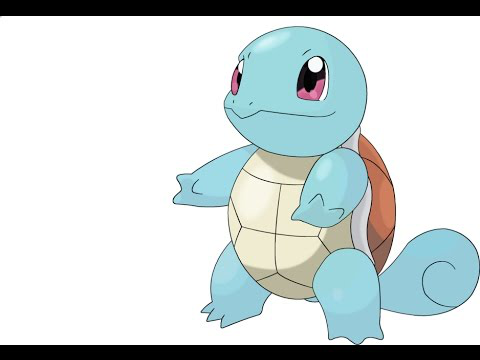

In [0]:
img = open_image(dataset_path/'squirtle/00000004.jpg')
img

In [0]:
learn = load_learner(dataset_path)

In [0]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category squirtle